# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 5
key = jax.random.PRNGKey(seed)
sample_key, shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 5)

gamma = 0.95

# Sample collection
n_actions = 2
oriented_state = jnp.array([0.5, 0.38])
n_random_samples = 3500
n_oriented_samples = 500
horizon_sample = 100
n_samples = n_random_samples + n_oriented_samples

# Weights collection
n_weights = 1

# Trainings
layers_dimension = (7, 7)
max_bellman_iterations = 15
batch_size_samples = n_samples

## Linear PBO
training_steps = 200
fitting_steps = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# Visualisation of errors and performances
n_states_x_visu = 17
n_states_v_visu = 17
horizon = 100

## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0

states_x_visu = jnp.linspace(-max_pos, max_pos, n_states_x_visu)
boxes_x_size = (2 * max_pos) / (n_states_x_visu - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x_visu + 1) - boxes_x_size / 2)
states_v_visu = jnp.linspace(-max_velocity, max_velocity, n_states_v_visu)
boxes_v_size = (2 * max_velocity) / (n_states_v_visu - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v_visu + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon_sample:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon_sample:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 118


In [4]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [0],
             [0],
             [0],
             [0],
             [1],
             [1],
             [0],
             [1],
             [1],
             [1],
             [1],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

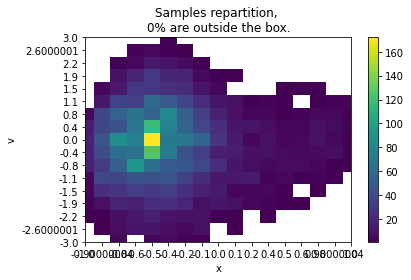

In [5]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

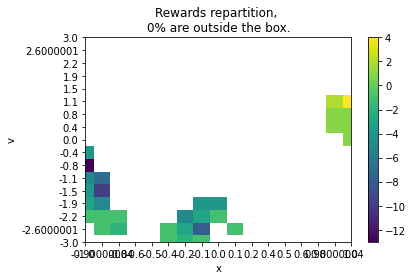

In [6]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train Q with Fitted-Q with enough power to make it working

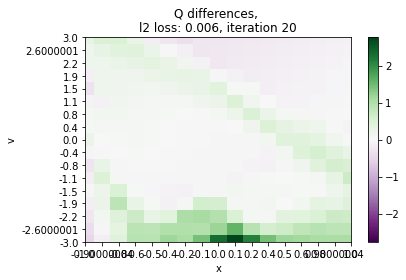

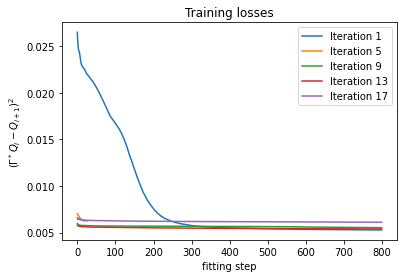

In [7]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_q = 20
fitting_steps_q = 800
batch_size_samples = n_samples

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations_q, fitting_steps_q)) * np.nan

for bellman_iteration in range(max_bellman_iterations_q):
    params_target = q.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss
        if cumulative_l2_loss / best_loss * 100 < 99.999:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1
        
        if patience > 5:
            break

    diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")


for bellman_iteration in range(0, max_bellman_iterations_q, max(max_bellman_iterations_q // 5, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

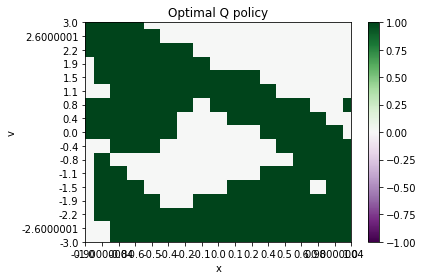

In [8]:
diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

In [9]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.13876191]
[0.16204378]

[-0.4803309  0.3866922]
[0.13876191]
[0.17856643]

[-0.4254183  0.690585 ]
[0.13876191]
[0.18453941]

[-0.34757635  0.83584267]
[0.13876191]
[0.17822513]

[-0.2641553   0.80664194]
[0.13876191]
[0.16188848]

[-0.19029287  0.65616035]
[0.13876191]
[0.14097175]

[-0.13487127  0.44623253]
[0.13876191]
[0.12575966]

[-0.12693372 -0.28545496]
[0.13876191]
[0.11737958]

[-0.19339946 -1.0595912 ]
[0.1292052]
[0.11135128]

[-0.34250036 -1.9302038 ]
[0.18984452]
[0.09224933]

[-0.5699506 -2.4868884]
[-0.6536788]
[0.07010269]

[-0.77525914 -1.5847647 ]
[-0.50683755]
[0.24811557]

[-0.8897677  -0.73244435]
[-0.04838139]
[0.27968588]

[-0.92570394  0.00366041]
[0.26992097]
[0.28363654]

[-0.88901484  0.7403888 ]
[0.17362612]
[0.26950642]

[-0.77363414  1.5943162 ]
[0.13876191]
[0.29320684]

[-0.5674046  2.493963 ]
[0.13876191]
[0.5423745]

[-0.3029607  2.5943394]
[0.7678969]
[0.6387942]

[-0.09944895  1.5136751 ]
[0.16843179]
[0.46649387]

[0.02998413 1.11118

DeviceArray([ True], dtype=bool)

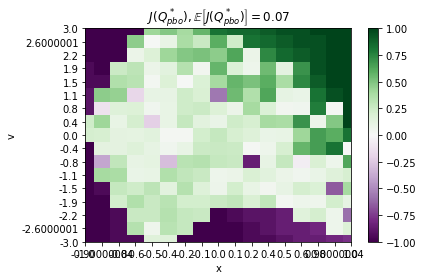

In [28]:
j_mesh = env.evaluate_mesh(q, horizon, n_states_x_visu, n_states_v_visu)

q_visu_mesh.set_values(j_mesh)
q_visu_mesh.show(r"$J(Q^*_{pbo}), \mathbb{E}\left[ J(Q^*_{pbo}) \right] =$" + str(np.round(np.mean(j_mesh), 2)), xlabel="x", ylabel="v")

## Collect weights

In [11]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

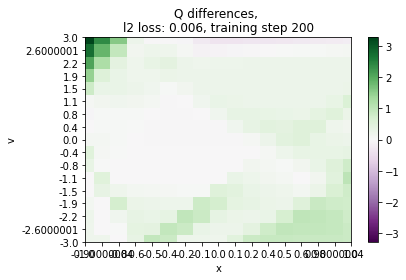

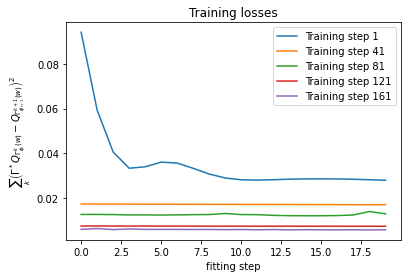

In [12]:
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, False, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    best_loss = float('inf')
    patience = 0

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss
        if cumulative_l2_loss / best_loss * 100 < 99.999:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > 7:
            break

    if not pbo.add_infinity:
        q_weight = data_loader_weights.weights[0]
        for _ in range(max_bellman_iterations):
            q_weight = pbo(pbo.params, q_weight)
    else:
        q_weight = pbo.fixed_point(pbo.params)
    q_pbo.params = q_pbo.to_params(q_weight)
    diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q_pbo)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, max(training_steps // 5, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

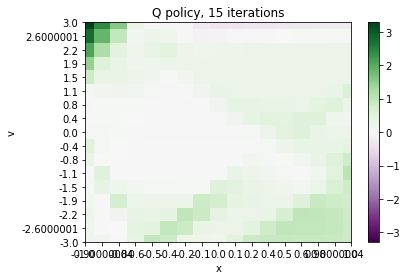

In [13]:
if not pbo.add_infinity:
    test_bellman_iterations = max_bellman_iterations

    q_weight = data_loader_weights.weights[0]
    for _ in range(test_bellman_iterations):
        q_weight = pbo(pbo.params, q_weight)
else:
    test_bellman_iterations = float("inf")
    q_weight = pbo.fixed_point(pbo.params)

q_pbo.params = q_pbo.to_params(q_weight)

diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(diff_q_pbo)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

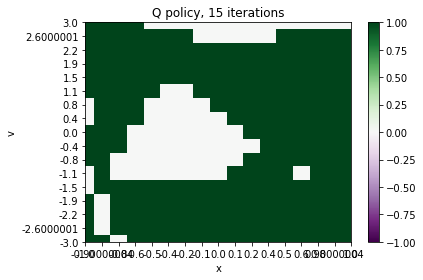

In [14]:
q_visu_mesh.set_values((diff_q_pbo > 0).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [26]:
env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.11515763]
[0.08720373]

[-0.5196691 -0.3866922]
[0.12702598]
[0.10512418]

[-0.57458174 -0.69058496]
[0.14153989]
[0.13089617]

[-0.6524237  -0.83584255]
[0.15526037]
[0.14461657]

[-0.73584473 -0.8066418 ]
[0.16552645]
[0.15372185]

[-0.80970716 -0.6561602 ]
[0.17162448]
[0.15609822]

[-0.86512876 -0.44623235]
[0.17257752]
[0.20056]

[-0.8730663   0.28545514]
[0.20477629]
[0.26242763]

[-0.8066006  1.0595914]
[0.20022935]
[0.3374096]

[-0.6574996  1.930204 ]
[0.27516106]
[0.46348262]

[-0.4300494  2.4868886]
[0.20842566]
[0.50379825]

[-0.19214995  2.1618748 ]
[0.30491215]
[0.5478816]

[-0.00494819  1.5880405 ]
[0.3156231]
[0.56239283]

[0.14226188 1.3974476 ]
[0.4393983]
[0.6861679]

[0.2791183 1.3560559]
[0.6145645]
[0.86133397]

[0.4165518 1.4087027]
[0.8321634]
[1.0789329]

[0.56418884 1.5603089 ]
[1.1079819]
[1.3547516]

[0.73154557 1.7994363 ]
[1.450412]
[1.6971815]

[0.9261602 2.101214 ]
[1.8591045]
[2.1058738]



DeviceArray([ True], dtype=bool)

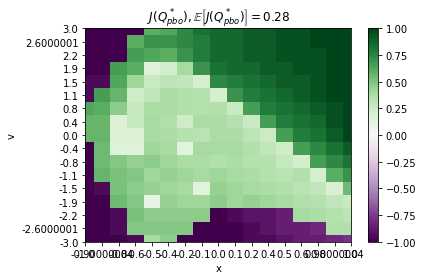

In [27]:
j_mesh_pbo = env.evaluate_mesh(q_pbo, horizon, n_states_x_visu, n_states_v_visu)

q_visu_mesh.set_values(j_mesh_pbo)
q_visu_mesh.show(r"$J(Q^*_{pbo}), \mathbb{E}\left[ J(Q^*_{pbo}) \right] =$" + str(np.round(np.mean(j_mesh_pbo), 2)), xlabel="x", ylabel="v")

In [21]:
j_mesh_pbo[8, 8]

0.37735360860824585

In [22]:
gamma ** 19

0.37735360253530725